## Correlations and Copulas Exercises
This notebook implements the more exercises involving Gaussian copulas

In [1]:
import numpy as np
import pandas as pd
import locale
from scipy.stats import uniform
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import triang
from math import sqrt

In [2]:
locale.setlocale(locale.LC_ALL, '')

'en_US.UTF-8'

#### Exercise 11.8
Answers from the textbook

 _ | 0.25 | 0.5 | 0.75
--- | --- | --- | ---
**0.25**|0.095|0.163|0.216
**0.5**|0.163|0.298|0.413
**0.75**|0.216|0.413|0.595

In [3]:
# V1 is uniform [0, 1], V2 is iniform [0, 1]
# Gaussian copula correlation between V1 and V2 is 0.3
u1u2_bivar = multivariate_normal(cov=[[1, .3],[.3, 1]])
uniform_obj = uniform()
normal_obj = norm()
quantiles = [.25, .5, .75]

In [4]:
# Maps 'x' percentile to percentile from the uniform [0, 1] to the standard normal distribution
from_uniform_to_normal = lambda x: normal_obj.ppf(uniform_obj.cdf(x))

In [5]:
# Let's map uniformly distributed values to those distributed using the standard normal distribution
mapped_quantiles = list(map(from_uniform_to_normal, quantiles))

In [6]:
# Constucting a cumulative distribution table as a numpy matrix
l = len(quantiles)
cum_matrix = np.empty((l, l), dtype=np.float64)
for i in range(l):
    for j in range(l):
        cum_matrix[i, j] = u1u2_bivar.cdf([mapped_quantiles[i], mapped_quantiles[j]])

In [7]:
# Converting to a dataframe for ease of display
cum_matrix_df = pd.DataFrame(cum_matrix, index=quantiles, columns=quantiles)
cum_matrix_df

,0.25,0.50,0.75
0.25,0.095103,0.163347,0.215757
0.50,0.163347,0.298493,0.413347
0.75,0.215757,0.413347,0.595103


#### Exercise 11.12
Answer from the textbook:

In [8]:
# First let's reconstruct the distributions of V1 and V2
triang1_obj = triang(c=.2)
triang2_obj = triang(c=.5)

# Copula correlation between V1 and V2
ρ = .5

u1u2_bivar = multivariate_normal(cov=[[1, ρ],[ρ, 1]])


# Maps 'x' percentile to percentile from a triangular to the standard normal distribution
from_v1_to_u1 = lambda x: normal_obj.ppf(triang1_obj.cdf(x))
from_v2_to_u2 = lambda x: normal_obj.ppf(triang2_obj.cdf(x))

# pdf of V2 conditional on V1
pdf_V2_conditional_on_V1 = lambda v2, v1: u1u2_bivar.pdf([from_v1_to_u1(v1), from_v2_to_u2(v2)]) / triang1_obj.pdf(v1)

# Table 11.3
quantiles = [i / 10 for i in range(1, 10)]

mapped_v1_quantiles = list(map(from_v1_to_u1, quantiles))
mapped_v2_quantiles = list(map(from_v2_to_u2, quantiles))
# Constucting a cumulative distribution table as a numpy matrix
l = len(quantiles)
cum_matrix = np.empty((l, l), dtype=np.float64)
for i in range(l):
    for j in range(l):
        cum_matrix[i, j] = u1u2_bivar.cdf([mapped_v1_quantiles[i], mapped_v2_quantiles[j]])
        
pd.DataFrame(cum_matrix, index=quantiles, columns=quantiles)

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0.1,0.006213,0.016789,0.027563,0.036870,0.043905,0.047756,0.049315,0.049857,0.049988
0.2,0.013233,0.043060,0.080730,0.120178,0.156425,0.180803,0.192954,0.198182,0.199804
0.3,0.017058,0.061219,0.123979,0.197462,0.273413,0.331430,0.364406,0.380674,0.386608
0.4,0.018708,0.070618,0.149407,0.247983,0.357611,0.448508,0.504860,0.535367,0.547817
0.5,0.019465,0.075617,0.164438,0.280647,0.416804,0.536791,0.616311,0.662648,0.683367
0.6,0.019804,0.078182,0.172954,0.300803,0.456425,0.600178,0.700730,0.763060,0.793233
0.7,0.019942,0.079384,0.177371,0.312215,0.480852,0.642312,0.760291,0.837387,0.877460
0.8,0.019988,0.079857,0.179315,0.317756,0.493905,0.666870,0.797563,0.886789,0.936213
0.9,0.019999,0.079987,0.179926,0.319719,0.499119,0.677826,0.815827,0.913117,0.969925


#### Exercise 11.14
Answer from the textbook: $42.68 million

In [9]:
# Total loans outstanding in $
L = 500_000_000

# Commond probability of default among loans
common_pd = .015

# Recovery rate of 30%
lgd = .7

# Copula correlation
ρ = .2

VaR_conf = .995

In [10]:
# Worst case default rate
wcdr = normal_obj.cdf(
    (normal_obj.ppf(common_pd) + sqrt(ρ) * normal_obj.ppf(VaR_conf)) / sqrt(1 - ρ))
var = L * lgd * wcdr

In [11]:
print("Exercise 11.14. One year VaR with a confidence level of %2.1f%%: %s"
              % (VaR_conf * 100, locale.currency(var, grouping=True)))

Exercise 11.14. One year VaR with a confidence level of 99.5%: $44,622,694.10


#### Exercise 11.15
This is a fairly complex exercise where I'll pull in TensorFlow 2 to tackle the optimization problem

Answers from the textbook: PD=3.92% and ρ=0.1118

In [12]:
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [13]:
# Annual default rates over 10 years
drs = np.array([.01, .09, .02, .03, .05, .01, .06, .07, .04, .01], dtype=np.float64)

In [14]:
# Using TensorFlow to look for optimal values of the copula correlation and probability of default using
# the maximum likelyhood method
ρ = tf.Variable(.11, dtype=tf.float64)
pd = tf.Variable(.013, dtype=tf.float64)

tfd = tfp.distributions

# Define a single scalar Normal distribution.
tf_normal_obj = tfd.Normal(loc=tf.constant(0., dtype=tf.float64), scale=tf.constant(1., dtype=tf.float64))

In [15]:
# Changing the sign due to Tensorflow's optimizers not having a 'maximize' method.
# When applying a function to a Tensor, the function must be a TensorFlow function, hence tf_normal_obj
# instead of normal_obj from scipy
probability_ln = lambda: tf.reduce_sum(-tf.math.log(tf.math.sqrt((1 - ρ)/ρ) * tf.math.exp(.5 * (
                             np.square(normal_obj.ppf(drs)) -
                              tf.math.square((tf.math.sqrt(1 - ρ)*normal_obj.ppf(drs) - tf_normal_obj.quantile(pd))/tf.math.sqrt(ρ)) )
                            )) )

In [16]:
print("Cost initially: %.7f" % probability_ln())
print("Starting values: \u03C1 = %.7f, pd = %.7f%%" % (ρ, pd*100))

Cost initially: -13.6580156
Starting values: ρ = 0.1100000, pd = 1.3000000%


In [17]:
opt = tf.keras.optimizers.Adam()
num_iter = 5000

step = 100
x = np.arange(0, num_iter // step)
y = np.zeros((3, num_iter // step))

for i in range(num_iter):
    opt.minimize(probability_ln, [ρ, pd])
    if i % step == 0:
        y[0, i // step] = probability_ln()
        y[1, i // step] = ρ
        y[2, i // step] = pd

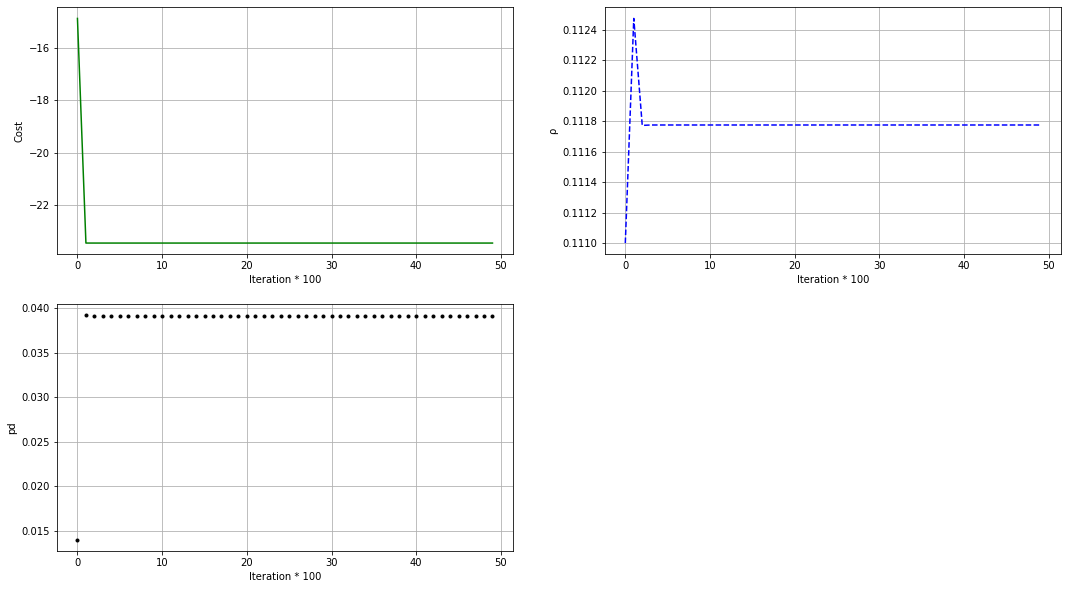

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(18, 10))
ax[0, 0].plot(x, y[0], 'g')
ax[0, 0].set_ylabel("Cost")
ax[0, 0].set_xlabel('Iteration * %u' % step)
ax[0, 0].grid()
ax[0, 1].plot(x, y[1], 'b--')
ax[0, 1].set_ylabel("\u03C1")
ax[0, 1].set_xlabel('Iteration * %u' % step)
ax[0, 1].grid()
ax[1, 0].plot(x, y[2], 'k.')
ax[1, 0].set_ylabel("pd")
ax[1, 0].set_xlabel('Iteration * %u' % step)
ax[1, 0].grid()
fig.delaxes(ax[1, 1])

In [19]:
print("Cost after running optimizer for %d iterations: %.7f" % (num_iter, probability_ln()))
print("New values: \u03C1 = %.7f, pd = %.7f%%" % (ρ, pd*100))

Cost after running optimizer for 5000 iterations: -23.4408813
New values: ρ = 0.1117741, pd = 3.9157100%


In [20]:
def  drPdf(ρ, pd, drs):
    ''' This function calculates the probability density function for annual default rates
    :param ρ: the copula correlation to use, it must be a scalar
    :param pd: the probability of default to use, it must be a scalar
    :param drs: the annual default rates, it must be a numpy array of floating point numbers in the range (0, 1)
    '''
    return  np.sqrt((1 - ρ)/ρ) * np.exp(.5 * (
                             np.square(normal_obj.ppf(drs)) -
                             np.square((np.sqrt(1 - ρ)*normal_obj.ppf(drs) - normal_obj.ppf(pd))/np.sqrt(ρ))
                               ))
                            

Text(0.5, 0, 'Default rate')

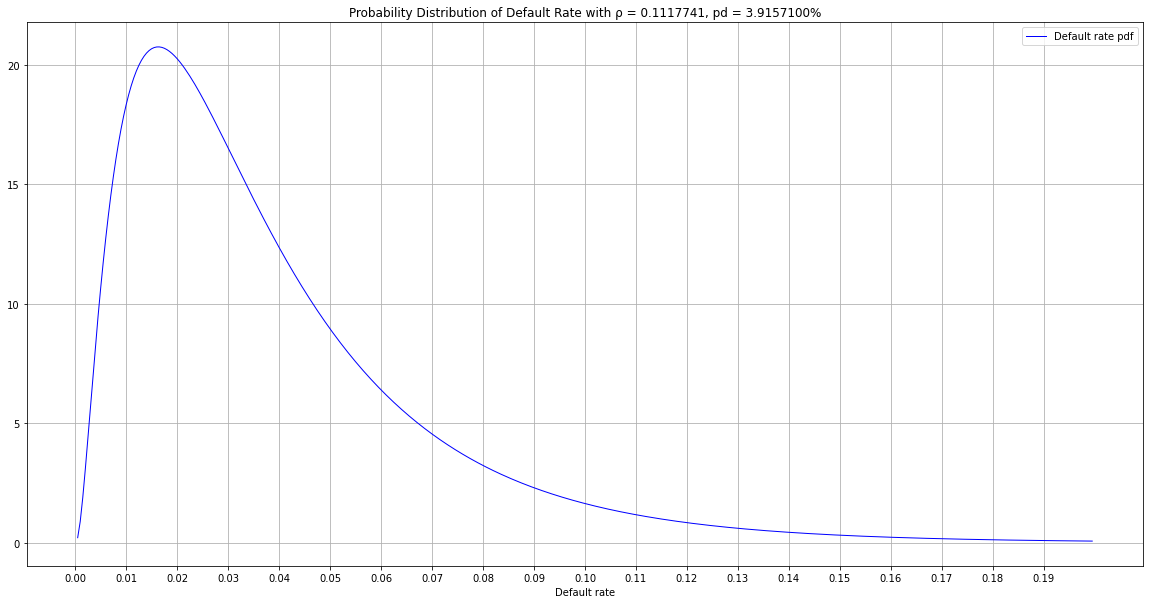

In [21]:
x = np.arange(5e-4, .2, 5e-4)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, drPdf(ρ, pd, x), label="Default rate pdf", linewidth=1, color='b')
ax.legend(loc='best')
ax.grid(True)
ax.set_xticks(np.arange(0, .2, .01))
ax.set_title('Probability Distribution of Default Rate with \u03C1 = %.7f, pd = %.7f%%' % (ρ, pd*100))
ax.set_xlabel('Default rate')